In [1]:
import os
import random

#data
import pandas as pd

# chemistry
import rdkit
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit import DataStructs
from rdkit.Chem import PandasTools
from rdkit.Chem import Lipinski

# math
import numpy as np

# plotting
from matplotlib import pyplot as plt

# Machine learning
import sklearn
from sklearn import tree

Here I am training a Decision Tree model to classify if two pairs of ligands are suitable for template based docking:

1) The continuous rmsd values are divided into 2 classes: the thershold for dividing between the two classes can be selected by choosing the one that best recovers pairs below 2 rmsd.

2) No values are considered inconclusive

3) Test set and training set don't have the same molecules

In [2]:
# get the data set
df = pd.read_csv('../data/train_test_rmsd_values_featurized_w_sasa_without_bad_pairs.csv')

df = df[df['template']!=df['docked']]
df = df.reset_index(drop=True)

# Assign binary labels to the dataset
df['binned_rmsd'] = None
thresholds =  [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2]
upper_thresholds = [2, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3, 3.1, 3.2, 3.3, 3.4, 3.5]
binned_rmsd = {threshold:{upper_threshold:[] for upper_threshold in upper_thresholds} for threshold in thresholds}
for index, rmsd in df[['rmsd']].itertuples():
    for i, threshold in enumerate(thresholds):
        for upper_threshold in upper_thresholds:
            if rmsd < threshold:
                binned_rmsd[threshold][upper_threshold] += [1]
            elif threshold < rmsd < upper_threshold:
                binned_rmsd[threshold][upper_threshold] += [-1]
            else:
                binned_rmsd[threshold][upper_threshold] += [0]

# Features that will be used to classify:
not_features = ['template', 'docked', 'rmsd', 'uniprot_id', 'mcs_smartsString',
                'smiles_template', 'smiles_docked', 'binned_rmsd']
features = df.drop(columns=not_features).columns.tolist()
print(features)


groups = []
size_of_groups = {}
for group in df['group'].drop_duplicates():
    groups +=  [group]
    size_of_groups[group] = df[df['group']==group].shape[0]

print(size_of_groups)


def check_sizes_of_folds(folds):
    sizes = []
    for fold in folds:
        sizes += [sum([size_of_groups[g] for g in fold])]
    return sizes

k = 4

base_size = len(groups)//(k)
base_rest = len(groups)%(k)

print(base_size, base_rest)

train_test_folds_dfs = []
train_test_folds_indexes = []
for number in range(3):

    random.shuffle(groups)
    folds = [groups[i*base_size:(i+1)*base_size] for i in range(k)]

    for i in range(base_rest):
        folds[-(i+1)] = np.append(groups[-(i+1)], folds[-(i+1)])

    print(check_sizes_of_folds(folds))

    folds_dfs = [[]]
    for fold in folds:
        for group in fold:
            folds_dfs[-1] += [df.loc[df['group']==group]]
        folds_dfs[-1] = pd.concat(folds_dfs[-1])
        folds_dfs += [[]]

    _train_test_folds_dfs = []
    for i in range(k):
        _train_test_folds_dfs += [[]]
        _train_test_folds_dfs[-1] += [pd.concat([folds_dfs[j] for j in range(k) if j!=i])]
        _train_test_folds_dfs[-1] += [folds_dfs[i]]

    _train_test_folds_indexes = []
    for train, test in _train_test_folds_dfs:
        _train_test_folds_indexes += [[train.index.values, test.index.values]]

    train_test_folds_dfs += _train_test_folds_dfs
    train_test_folds_indexes += _train_test_folds_indexes

['template_HeavyAtomCount', 'template_NHOHCount', 'template_NOCount', 'template_RingCount', 'template_NumHAcceptors', 'template_NumHDonors', 'template_NumHeteroAtoms', 'template_NumRotatableBonds', 'docked_HeavyAtomCount', 'docked_NHOHCount', 'docked_NOCount', 'docked_RingCount', 'docked_NumHAcceptors', 'docked_NumHDonors', 'docked_NumHeteroAtoms', 'docked_NumRotatableBonds', 'mcs_HeavyAtomCount', 'mcs_NOCount', 'mcs_RingCount', 'mcs_NumHeteroAtoms', 'mcs_template_NHOHCount', 'mcs_docked_NHOHCount', 'mcs_template_NumHAcceptors', 'mcs_docked_NumHAcceptors', 'mcs_template_NumHDonors', 'mcs_docked_NumHDonors', 'mcs_template_NumRotatableBonds', 'mcs_docked_NumRotatableBonds', 'ec_tanimoto_similarity', 'fc_tanimoto_similarity', 'mcs_bonded_polar_sasa', 'mcs_bonded_apolar_sasa', 'mcs_unbonded_polar_sasa', 'mcs_unbonded_apolar_sasa', 'sasa_bonded_polar', 'sasa_bonded_apolar', 'sasa_unbonded_polar', 'sasa_unbonded_apolar', 'group']
{1: 7399, 2: 4296, 5: 788, 6: 1053, 9: 408, 10: 695, 11: 593, 

In [3]:
from tools import test_interval_of_inconclusives
train_test=random.sample(train_test_folds_dfs, len(train_test_folds_dfs)).copy()

In [4]:
# Decision tree maximum_depth = 3 and evaluation_threshold = [1, 1.5, 2]
data_dt_3=test_interval_of_inconclusives.test_threshold(train_test, 3, [2], thresholds, upper_thresholds, binned_rmsd, not_features)

In [ ]:

# Decision tree maximum_depth = 4 and evaluation_threshold = [1, 1.5, 2]
data_dt_4=test_threshold.test_threshold(train_test, 4, [2], thresholds, binned_rmsd, not_features)


In [ ]:

# Decision tree maximum_depth = 5 and evaluation_threshold = [1, 1.5, 2]
data_dt_5=test_threshold.test_threshold(train_test, 5, [2], thresholds, binned_rmsd, not_features)


In [ ]:

# Decision tree maximum_depth = 6 and evaluation_threshold = [1, 1.5, 2]
data_dt_6=test_threshold.test_threshold(train_test, 6, [2], thresholds, binned_rmsd, not_features)


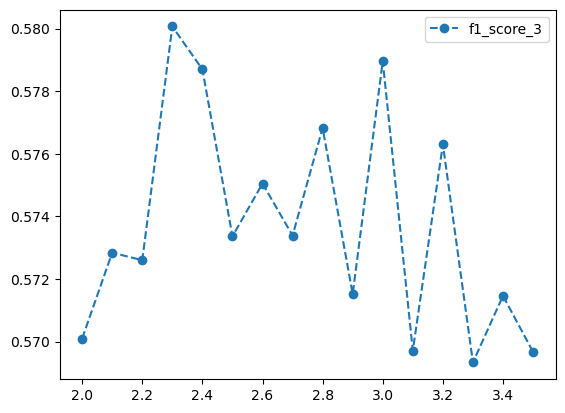

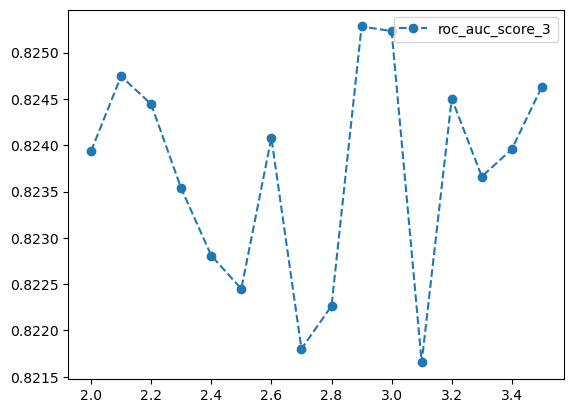

In [16]:
plt.style.use('default')
#plt.style.use({'figure.facecolor':'white'})
evaluation_threshold = 2
threshold = 2
#for dt, depth in zip([data_dt_3, data_dt_4, data_dt_5, data_dt_6], [3,4,5,6]):
#for dt, depth in zip([data_dt_3], [3]):
#    precision = dt['precision_mean']
#    plt.plot(upper_thresholds,[precision[evaluation_threshold][threshold][upper_threshold] for upper_threshold in upper_thresholds], '--o', label='precision_'+str(depth))
#plt.legend()
#plt.show()

#for dt, depth in zip([data_dt_3, data_dt_4, data_dt_5, data_dt_6], [3,4,5,6]):
for dt, depth in zip([data_dt_3], [3]):
    f1_score = dt['f1_score_mean']
    plt.plot(upper_thresholds, [f1_score[evaluation_threshold][threshold][upper_threshold] for upper_threshold in upper_thresholds], '--o',label='f1_score_'+str(depth))
plt.legend()
plt.show()

#for dt, depth in zip([data_dt_3, data_dt_4, data_dt_5, data_dt_6], [3,4,5,6]):
#for dt, depth in zip([data_dt_3], [3]):
#    recall = dt['recall_mean']
#    plt.plot(upper_thresholds, [recall[evaluation_threshold][threshold][upper_threshold] for upper_threshold in upper_thresholds], '--o',label='recall_'+str(depth))
#plt.legend()
#plt.show()

#for dt, depth in zip([data_dt_3, data_dt_4, data_dt_5, data_dt_6], [3,4,5,6]):
for dt, depth in zip([data_dt_3], [3]):
    roc_auc_score = dt['roc_auc_score_mean']
    mean = 1#np.mean([roc_auc_score[evaluation_threshold][threshold] for threshold in thresholds])
    plt.plot(upper_thresholds,[roc_auc_score[evaluation_threshold][threshold][upper_threshold] for upper_threshold in upper_thresholds],'--o', label='roc_auc_score_'+str(depth))
plt.legend()
plt.show()